# Deflation Methods for Equilibrium and Optimization

This notebook introduces deflation methods, and shows how to use them in two examples for equilibrium solving and stellarator optimization.

## Background

Nonlinear system rootfinding $\mathbf{F}(\mathbf{x})=0$ can exhibit multiple roots (simplest case being polynomial rootfinding with scalar $x$). Newton's method is often used to rootfind, but which root is found depends on the initial guess for the method. Deflation was developed to try to allow convergence to multiple roots from the same initial guess for the rootfinding method. This is done by finding a first root, then "deflating away" that root by multiplying the original system by a deflation operator and then rootfinding on that augmented system. Concretely, let

$$
\begin{equation}
    \mathbf{F}(\mathbf{x}) = 0
\end{equation}
$$

where $\mathbf{F}$ is the nonlinear system of equations being solved and $\mathbf{x}$ is the state vector of unknowns. The deflation algorithm works by attempting to find a set of distinct solutions $\{\mathbf{x}_1^*, \mathbf{x}_2^*, ...\}$. Suppose a solution is found $\mathbf{x}_1^*$ to the above equation (by application of Newton's method, or some other way such as minimization of the residual). To find more solutions, one may apply a deflation operator to modify the system being solved, instead solving

$$
\begin{equation}
    M(\mathbf{x};\mathbf{x}_1^*)\mathbf{F}(\mathbf{x})=0
\end{equation}
$$

where

$$
\begin{equation}
    M(\mathbf{x};\mathbf{x}_1^*) = \left(\frac{1}{| \mathbf{x}-\mathbf{x}_1^* |^p_2}\right) + \sigma
\end{equation}
$$

is the deflation operator with power and shift parameters $p>0$ and $\sigma>0$, respectively, and $| \cdot |_2$ is the Euclidean norm. Solving the deflated system encourages the nonlinear solver to not return the known solution $\mathbf{x}_1^*$ (from the same initial guess) but rather a distinct solution $\mathbf{x}_2^*$ (if the nonlinear solver converges, which is not always guaranteed). To find further solutions, the system can then be deflated again using known solutions $\{\mathbf{x}_1^*,...,\mathbf{x}_N^*\}$ by simply applying the deflation operator repeatedly:

$$
\begin{equation}
    \prod_{i=1}^N M(\mathbf{x};\mathbf{x}_i^*)\mathbf{F}(\mathbf{x}) = 0
\end{equation}
$$

With this deflation method, one may find multiple solutions to a given system of equations. In DESC, it can be applied to find multiple solutions to various equilibrium problems , where the nonlinear system being solved is the ideal magneto-hydrodynamic (MHD) equilibrium force balance, and minimization techniques are applied to find the solutions to the unmodified and modified system. 

This can also be applied to nonconvex optimization (which many stellarator optimization problems are). One can either use the above form to modify the objective function being minimized to with the deflation operator, or one can apply a nonlinear constraint to enforce the deflation (either as an additional term to be penalized or as a nonlinear constraint through a constrained optimizer like `lsq-auglag`). The constraint would be of the form

$$
\begin{equation}
M(\mathbf{x};\mathbf{x_1}) \leq r
\end{equation}
$$

Where $r>0$ is some positive constant. This constraint then would encourage the optimizer to not find minima similar to already-found minima.

# Near Axis Constrained Equilibria

Near-axis-constrained equilibrium is an under-constrained problem which has multiple solutions. We can apply deflation to find these solutions. In this section, we will apply this to a QA NAE solution to find three different global equilibria which match the same near-axis properties

In [1]:
# uncomment these if you have a GPU for a speedup!
# from desc import set_device
# set_device("gpu")

In [2]:
from desc.objectives import (
    DeflationOperator,
    ForceBalance,
    get_NAE_constraints,
    get_fixed_boundary_constraints,
    ObjectiveFunction,
)
from desc.io import load

# must have installed pyQsc with `pip install qsc` in order to run this notebook!
from qsc import Qsc
import numpy as np
import matplotlib.pyplot as plt
import os
from desc.equilibrium import Equilibrium
from desc.plotting import (
    plot_comparison,
    plot_fsa,
    plot_section,
    plot_surfaces,
    plot_qs_error,
    plot_1d,
    plot_boundaries,
    plot_boozer_surface,
)

plt.rcParams.update({"font.size": 20})

As mentioned in [DESC Documentation on performance tips](https://desc-docs.readthedocs.io/en/latest/performance_tips.html), one can use compilation cache directory to reduce the compilation overhead time. Note: One needs to create `jax-caches` folder manually.

In [3]:
# import jax

# jax.config.update("jax_compilation_cache_dir", "../jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [4]:
qsc_eq = Qsc.from_paper("precise QA", order=1)
ntheta = 12  # only using M=5 for our equilibrium, so we don't need a large ntheta
r = 0.25


eq_fit = Equilibrium.from_near_axis(
    qsc_eq,  # the Qsc equilibrium object
    r=r,  # the finite radius (m) at which to evaluate the Qsc surface to use as the DESC boundary
    L=5,  # DESC radial resolution
    M=5,  # DESC poloidal resolution
    N=6,  # DESC toroidal resolution
    ntheta=ntheta,
)

In [5]:
def solve_deflated(eq_fit, eqs_to_deflate=[], power=2, sigma=1):
    # Helper Function for using deflation to find multiple NAE-constrained equilibria

    # only perform deflation step if eqs_to_deflate is not empty or is not all None
    # if isinstance(eqs_to_deflate, list):
    #     if len(eqs_to_deflate) > 0 and not np.all([t is None for t in eqs_to_deflate]):
    #         pass
    #     else:
    #         eqs_to_deflate = None

    eq = eq_fit.copy()
    constraints = get_NAE_constraints(
        eq, qsc_eq, order=1
    )  # get the first-order NAE constraints
    # create the force balance objective, which we will use both in the deflation and to solve the NAE-constrained and final fixed-boundary solve
    force_obj_bare = ForceBalance(eq)
    force_obj = ObjectiveFunction(force_obj_bare)

    if eqs_to_deflate is not None:
        # solve deflated
        deflated_force_obj = ObjectiveFunction(
            DeflationOperator(
                thing=eq,
                things_to_deflate=eqs_to_deflate,
                objective=force_obj_bare,
                power=power,
                sigma=sigma,
                # params_to_deflate is a dictionary
                params_to_deflate_with={"Rb_lmn": True, "Zb_lmn": True},
            )
        )
        eq.solve(
            verbose=1,
            ftol=1e-3,
            objective=deflated_force_obj,
            # only do a few iterations, to just get into a different basin of attraction for another NAE-constrained equilibrium solution
            maxiter=15,
            xtol=1e-6,
            constraints=constraints,
        )
    # then solve just NAE-constrained equilibrium solve so it falls in new local minimum
    eq.solve(
        verbose=1,
        ftol=1e-3,
        objective=force_obj,
        maxiter=50,
        xtol=1e-7,
        constraints=constraints,
    )
    # then solve fixed boundary to confirm is indeed equilibrium in usual sense
    eq.solve(ftol=1e-3, maxiter=50, objective=force_obj)

    return eq

With the above helper function, we can call it in a loop as many times as we'd like to get any number of NAE-constrained equilibrium solutions. For brevity's sake this notebook will only run it three times.

In [6]:
# this can be increased if more local minima are desired, though
# there is no guarantee that every solution found is "good",
# e.g. convergence to a new good solution is not guaranteed
N_deflation = 3
# we can either append to the list of equilibria we are deflating with as we go, or
# we can make the full list length we expect and fill it with None to start. The
# latter is advantageous as it will avoid recompilation of our deflation objective
# in subsequent iterations, so we will use that approach.
eqs = [None] * N_deflation
for i in range(N_deflation):
    print("#" * 20)
    print(f"{i=}")
    print("#" * 20)
    eqs[i] = solve_deflated(eq_fit, eqs, sigma=500).copy()

####################
i=0
####################
Building objective: Deflated force
Precomputing transforms
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: Fix Near Axis R Behavior
Building objective: Fix Near Axis Z Behavior
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Number of parameters: 369
Number of objectives: 1800

Starting optimization
Using method: lsq-exact
         Current function value: 2.843e-06
         Total delta_x: 3.063e-01
         Iterations: 15
         Function evaluations: 21
         Jacobian evaluations: 16
                                                                 Start  -->   End
Total (sum of squares):                                      1.857e+00  -->   2.843e-06, 
Maximum absolute Deflated 

Now that we have our two solutions, we can check them and see how they differ by comparing their boundaries:

We see from their force errors that each are good equilibria with normalized force errors <1%. They also have different rotational transform profiles, though notably have the same near-axis properties (as expected given that all are NAE-constrained equilibria constrained by the same NAE solution):

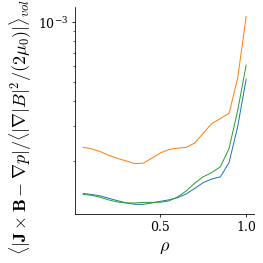

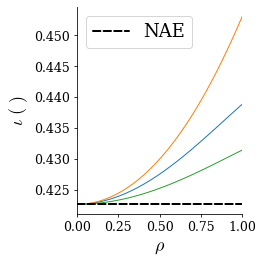

In [7]:
cs = ["tab:blue", "tab:orange", "tab:green", "c"]
plt.rcParams.update({"font.size": 18})
ax = None
ax2 = None
for i in range(len(eqs)):
    fig, ax = plot_fsa(eqs[i], "|F|_normalized", log=True, ax=ax, color=cs[i])
    fig2, ax2 = plot_1d(eqs[i], "iota", ax=ax2, color=cs[i])
ax2.axhline(qsc_eq.iota, c="k", linestyle="--", label="NAE", lw=2)
ax2.set_xlim([0, 1.0])

ax2.legend()

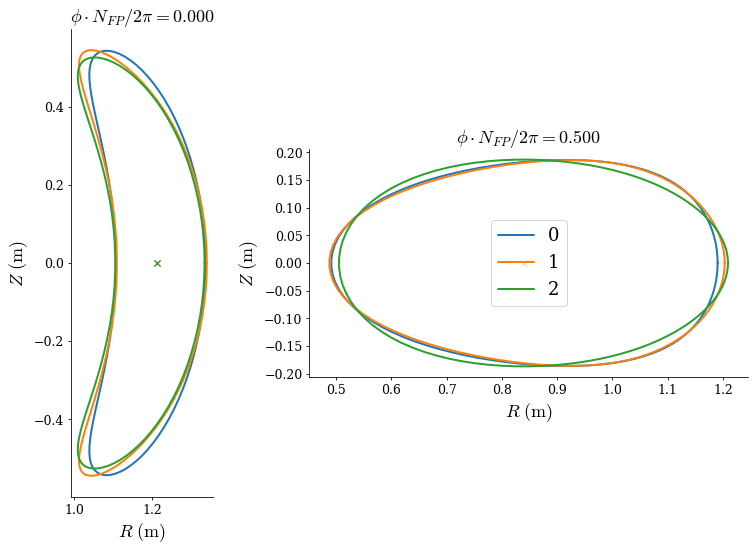

In [8]:
eq = eq_fit
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
phis = np.linspace(0, np.pi / eq.NFP, 2, endpoint=True)
fig, ax = plot_boundaries(eqs, lw=2, color=cs, legend=False, phi=phis[0], ax=axes[0])
fig, ax = plot_boundaries(eqs, lw=2, color=cs, legend=True, phi=phis[1], ax=axes[1])
for i, axx in enumerate(axes.flatten()):
    axx.set_aspect("equal")
    axx.set_title(r"$\phi\cdot N_{FP}/2\pi=$" + rf"${phis[i]*eq.NFP/2/np.pi:1.3f}$")

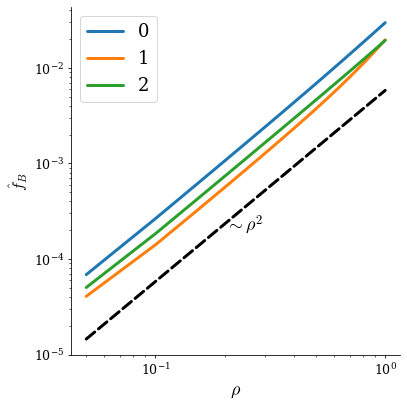

In [9]:
ax = None
for i in range(len(eqs)):
    fig, ax, dataQS = plot_qs_error(
        eqs[i],
        labels=[f"{i}"] * 3,
        fC=False,
        fT=False,
        fB=True,
        log=True,
        color=[cs[i]] * 3,
        ax=ax,
        legend=False,
        marker=[None] * 3,
        return_data=True,
        lw=[3] * 3,
    )
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(
    dataQS["rho"],
    dataQS["rho"] ** 2 * (np.max(dataQS["f_B"]) * 0.3),
    "k--",
    lw=3,
)
ax.text(0.2, 2e-4, r"$\sim \rho^2$", size=18)
ax.legend()
ax.set_ylabel(r"$\hat{f}_B$", fontsize=16);

## QH Optimization

Now, we will perform a stage-one QH optimization three times: the first time will result in some QH solution, while the second and third times we will use the DeflationOperator as a nonlinear constraint to penalize the problem from finding the same solutions again. The constraint will be of the form

\begin{equation}
M(\mathbf{x};\{\mathbf{x}_i^*\})\leq r
\end{equation}

where $r$ is the upper bound on the deflation metric cost (the lower the deflation metric cost, the farther the solution is away from the already-found solutions as measured by the deflation operator detailed above) and $\{\mathbf{x}_i^*\}$ is the set of already-found local minima which we wish to avoid.

In [10]:
from desc.continuation import solve_continuation_automatic
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.geometry import FourierRZToroidalSurface
from desc.grid import LinearGrid
from desc.objectives import (
    AspectRatio,
    FixBoundaryR,
    FixBoundaryZ,
    FixCurrent,
    FixPressure,
    FixPsi,
    ForceBalance,
    ObjectiveFunction,
    QuasisymmetryTwoTerm,
    RotationalTransform,
)
from desc.optimize import Optimizer
from desc.compat import rotate_zeta

# create initial equilibrium, just a circular torus
surf = FourierRZToroidalSurface(
    R_lmn=[1, 0.125, 0.0],
    Z_lmn=[-0.125, -0.0],
    modes_R=[[0, 0], [1, 0], [0, 1]],
    modes_Z=[[-1, 0], [0, -1]],
    NFP=4,
)
eq = Equilibrium(L=4, M=3, N=4, Psi=0.04, surface=surf)

In [11]:
# grid to use to evaluate QH two-term errors at
grid = LinearGrid(M=eq.M, N=eq.N, NFP=eq.NFP, rho=np.array([0.6, 0.8, 1.0]), sym=True)


def run_and_deflate(eq, eqs_deflate, r=5):
    # Helper Function for using deflation to find multiple QH equilibria

    this_eq = eq.copy()

    objs = (
        QuasisymmetryTwoTerm(
            eq=this_eq,
            helicity=(1, eq.NFP),
            grid=grid,
        ),
    )

    constraints = (
        ForceBalance(eq=this_eq),  # J x B - grad(p) = 0
        FixBoundaryR(
            eq=this_eq, modes=[[0, 0, 0]]
        ),  # we fix the R_000 mode corresponding to the major radius
        FixPressure(eq=this_eq),
        FixCurrent(eq=this_eq),
        FixPsi(eq=this_eq),
        AspectRatio(eq=this_eq, target=8),
        RotationalTransform(this_eq, bounds=(0.7, 3), loss_function="mean"),
    )
    if len(eqs_deflate) > 0:
        constraints += (
            DeflationOperator(
                this_eq,
                eqs_deflate,
                sigma=0,
                bounds=(0, r),
                power=2,
            ),
        )  # by default, the part of the state used in the deflation is the entire state i.e. Rlmn Zlmn Llmn etc,
        # every part of the eq.params_dict is included in the state.
    objective = ObjectiveFunction(objs)

    optimizer = Optimizer("lsq-auglag")
    this_eq.optimize(
        objective=objective,
        constraints=constraints,
        optimizer=optimizer,
        maxiter=300,
        ftol=1e-2,
        verbose=1,
        x_scale="ess",
    )
    this_eq.solve(ftol=5e-3, verbose=0)
    return this_eq

In [12]:
# this can be increased if more local minima are desired, though
# there is no guarantee that every solution found is "good",
# e.g. convergence to a new good solution is not guaranteed
N_deflation = 3
eqs = (
    [None] * N_deflation * 2
)  # we will have 2*N_deflation total eqs to deflate since we are
# including the potential degenerate rotations as well
for i in range(0, N_deflation):
    print("#" * 20)
    print(f"{i=}")
    print("#" * 20)
    eqs[i] = run_and_deflate(eq, eqs).copy()
    # also add to the list of deflated solutions the other possible parametrization
    # of the same physical equilibrium in stellarator symmetry, which is the pi/NFP
    # toroidally rotated equilibrium
    # to avoid the exact same equilibrium being found
    # This is unneeded for the NAE-constrained equilibria in the prior section
    # because the NAE constraints on the axis and first-order behavior remove this possible
    # parametrization degeneracy
    eqs[-(i + 1)] = rotate_zeta(eqs[i].copy(), angle=np.pi / eq.NFP)

####################
i=0
####################
Building objective: QS two-term
Precomputing transforms
Building objective: lcfs R
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Building objective: force
Precomputing transforms
Building objective: aspect ratio
Precomputing transforms
Building objective: rotational transform
Precomputing transforms
Building objective: Deflation
Number of parameters: 173
Number of objectives: 108
Number of equality constraints: 715
Number of inequality constraints: 2

Starting optimization
Using method: lsq-auglag
         Current function value: 2.338e-06
         Constraint violation: 2.572e-04
         Total delta_x: 5.764e-01
         Iterations: 300
         Function evaluations: 559
         Jacobian eva

In [13]:
eqs = eqs[0:N_deflation]  # only keep the physically unique equilibria here

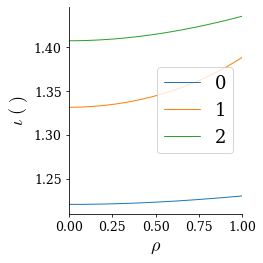

In [14]:
from desc.plotting import *

plt.rcParams.update({"font.size": 18})
ax2 = None
for i in range(len(eqs)):
    fig2, ax2 = plot_1d(eqs[i], "iota", ax=ax2, color=cs[i], label=str(i))
ax2.set_xlim([0, 1.0])
ax2.legend()

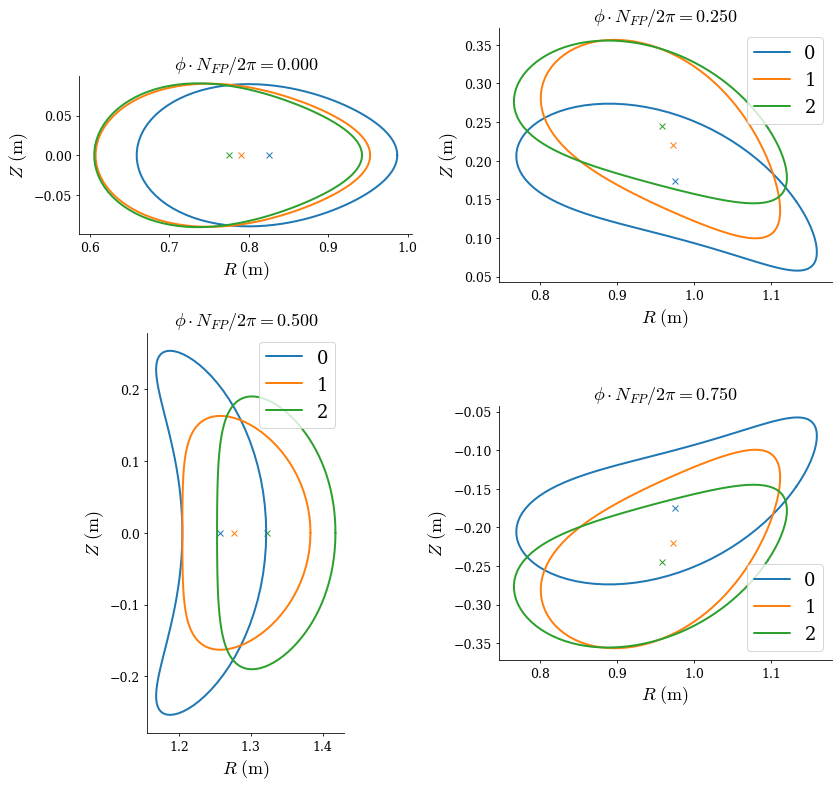

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()
phis = np.linspace(0, 2 * np.pi / eqs[0].NFP, 4, endpoint=False)
fig, ax = plot_boundaries(eqs, lw=2, color=cs, legend=False, phi=phis[0], ax=axes[0])
fig, ax = plot_boundaries(eqs, lw=2, color=cs, legend=True, phi=phis[1], ax=axes[1])
fig, ax = plot_boundaries(eqs, lw=2, color=cs, legend=True, phi=phis[2], ax=axes[2])
fig, ax = plot_boundaries(eqs, lw=2, color=cs, legend=True, phi=phis[3], ax=axes[3])

for i, axx in enumerate(axes):
    axx.set_aspect("equal")
    axx.set_title(r"$\phi\cdot N_{FP}/2\pi=$" + rf"${phis[i]*eqs[0].NFP/2/np.pi:1.3f}$")

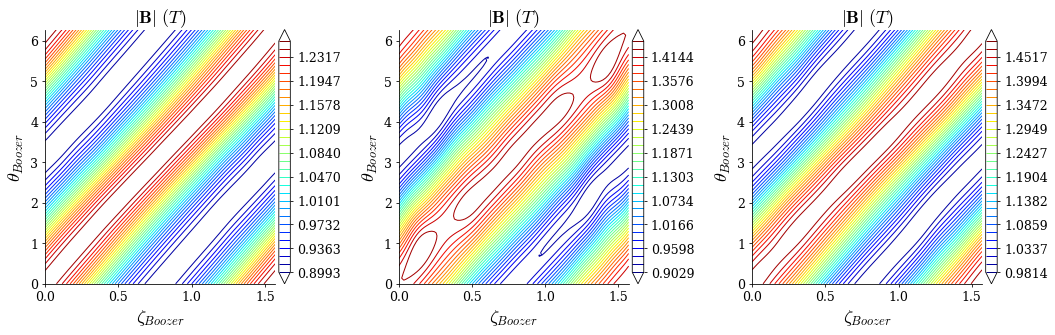

In [16]:
fig, ax = plt.subplots(1, N_deflation, figsize=(N_deflation * 5, 5))
ax = ax.flatten()
for i in range(len(eqs)):
    plot_boozer_surface(eqs[i], ax=ax[i])